# Executive summary 

**Finding it hard to find volunteer moderators for your forums to enforce rules? Worried about these volunteer moderators becoming inactive and them holding onto admin access? Worried about too much clutter/spam building up into your forums that people would view your forum with lower regard?**

**Fret not**
<br>We propose the research,building and implementation of a NLP classifier model. The model here however would not be a multi-class classification model but rather a binary classification model. The goal of the project is to be a proof of concept that machine-learning classifier systems could work for forums. If the proof of concept model could work, management can reconsider allocating more budget to build a more enhanced deployment model for multiclass classification.

Based on our research, building and testing of models in the notebook below, we were able to utilise a countvectorizer and logistic regression to predict from which subreddit (r/nosleep or r/UnsolvedMysteries) a post is from with up to a accuracy of 99.39%. We would need more resources and time to research and test the feasibility to deploy it on a whole forum basis.</br>

Our research process as usual..

**The Data Science Process**
- Problem Statement
- Data Collection
- Data Cleaning & Preprocessing
- EDA & Modeling
- Evaluation and Conceptual Understanding
- Conclusion and Recommendations

# 1. Problem Statement
---

To use NLP to train a classifier to predict from which subreddit (either r/nosleep or r/UnresolvedMysteries) a given post came from. This is a binary classification problem.


r/nosleep: Nosleep is a subreddit for realistic horror stories.
<br>r/UnresolvedMysteries: UnresolvedMysteries is a subreddit dedicated to the unresolved mysteries of the world.</br>

In [1]:
# Import libraries
import pandas as pd
import regex as re
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud, ImageColorGenerator

# 2. Data Collection
---

Data Collection is done in another notebook. Codes are not in this workbook to prevent long waiting time to loop through posts, download and override existing datasets and affect the results.

Brief steps of the process is discussed here.

<ol>
    <li>Using the python `requests` library to connect to the subreddit url via reddit's json</li>
    <li>Make sure that the status code is correct and properly connected.</li>
    <li>Wrote a loop and ran the loop parsing the base url and the query to go to the next 40 posts until it loops to collect 1000post and exports it to a csv file.</li>
    <li>Check the length of the list and the number of empty posts.</li>
    <li>Repeat for the other subreddit</li>
</ol>
<br>    
</br>    

# 3. Data Cleaning
---

Data (posts webscrapped from reddit) from the other notebook is imported here for further data cleaning.

Technically, there were no empty posts when we tried to gather data but when we import and check for null values in this workbook there are a total of 10 empty posts. The empty posts were post filled with a (space) in the post. The (space) character is not captured in the export/import of csv.

After dropping the rows containing the null stories, we proceed to clean the data by writing a function that:
<ol>
    <li>Remove HTML tags</li>
    <li>Remove non-letter, remove some html tags that people use on reddit to get extra "breaks" in the post, removing the sub reddit tags</li>
    <li>Convert to lower case, split into individual words</li>
    <li>In Python, searching a set is much faster than searching a list, so convert the stop words to a set.</li>
    <li>Remove stop words</li>
    <li>Lemmatize the words</li>
    <li>Join the words back into one string separated by space and return the result.</li>
</ol>

**we use the scikit learn stop words instead of the nltk's stop words as there are more stop works in it**
    

In [2]:
# Import data nosleep.csv which is data collected from reddit r/nosleep
# Nosleep is a subreddit for realistic horror stories.

nosleep = pd.read_csv('nosleep.csv')

In [3]:
# to see total number of webscrapped post for sub-reddit r/nosleep
len(nosleep)

994

In [4]:
# set classifying label for r/nosleep as 0, unresolved mysteries as 1.
# post usually have a title and a post
nosleep['label'] = 0
nosleep = nosleep[['label','title','selftext']]

In [5]:
nosleep.head(10)

,label,title,selftext
0,0,Spooktober! 31 Days of Horror Nosleep Event,NaN
1,0,August 2019 Voting Thread,NaN
2,0,"I just graduated from medical school, and my n...",You probably think that all doctors are filthy...
3,0,"When I see the pale faceless dancer, someone I...","I’ve seen her five times, and every time someo..."
4,0,"My Mom Never Told Me She was in Ballet, Here's...","Recently, I found something out about my mothe..."
5,0,I found out the horrifying truth of why sleep ...,We never remember the exact moment we fall asl...
6,0,My friend's skinwalker story,Back in college a buddy and I were hanging out...
7,0,My Best Friend Took Me To My First Strip Club ...,"""Steven, tonight's the night you become a man!..."
8,0,I'm standing watch over a man's dead daughter ...,[The first night.](https://www.reddit.com/r/no...
9,0,My Grandma Said Something Strange,I moved in with my grandma a year ago after we...


<br>

`title` is usually one liner which maybe the opening line of the story or a real title for the story. Decided to drop and not do analysis on it as it is too short and use the main body text.


In [6]:
nosleep.isnull().sum()

label       0
title       0
selftext    5
dtype: int64

In [7]:
nosleep = nosleep[['label','selftext']]
nosleep.dropna(axis=0,how='any',inplace=True)
nosleep.drop_duplicates(subset='selftext', keep='last', inplace=True)
print(len(nosleep))
nosleep.head()

814


,label,selftext
176,0,So theres this huge park near my house in west...
177,0,[Part 1](https://www.reddit.com/r/nosleep/comm...
178,0,"After college, I moved to Japan to teach Engli..."
179,0,Hi im Jane. I want tell you a story of somethi...
180,0,The following is from an old notebook found in...


Dropped 5 rows from the data set due to missing content `selftext`. Dropped 175 rows of duplicate content.

<br>

Now, proceed to clean data from reddit UnresolvedMysteries.

In [8]:
mystery = pd.read_csv('UnresolvedMysteries.csv')

In [9]:
len(mystery)

999

In [10]:
mystery['label'] = 1
mystery = mystery[['label','selftext']]

In [11]:
mystery.isnull().sum()

label       0
selftext    5
dtype: int64

In [12]:
mystery.dropna(axis=0,how='any',inplace=True)
mystery.drop_duplicates(subset='selftext', keep='last', inplace=True)
print(len(mystery))
mystery.head()

560


,label,selftext
427,1,I recently finished the To Live and Die in LA ...
428,1,"\nIn 1993, Shelley Connors was 17 years old. S..."
429,1,Like cases where everything lines up to one sp...
430,1,**Case Info**\n\nRaymond Wright was 55 years o...
431,1,Summary- Thomas Brown was a teenager from Cana...


<br>

Dropped 5 rows from the data set due to missing content `selftext`. Dropped 434 duplicate rows.

<br>

In [13]:
combined = nosleep.append(mystery)
combined.reset_index(inplace=True,drop=True)
combined.head()

,label,selftext
0,0,So theres this huge park near my house in west...
1,0,[Part 1](https://www.reddit.com/r/nosleep/comm...
2,0,"After college, I moved to Japan to teach Engli..."
3,0,Hi im Jane. I want tell you a story of somethi...
4,0,The following is from an old notebook found in...


In [14]:
#write a function to convert a long form reddit post to a string of words
def cleanreview(raw_post):
    
    # 1. Remove HTML.
    post_text = BeautifulSoup(raw_post).get_text()
    
    # 2. Remove non-letter, remove some html tags that people use on reddit to get extra "breaks" in the post, removing the sub reddit tags
    letters_only = re.sub("[www.reddit.com]{14}|[r\/nosleep]{9}|[r\/UnresolvedMysteries]{22}|[&#x200B;]{8}|[&nbsp;]{6}|[^A-z0-9]|\[|\]", " ", post_text)
    
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
        
    # 4. In Python, searching a set is much faster than searching
    # a list, so convert the stop words to a set.
    stops = set(stop_words.ENGLISH_STOP_WORDS)
    
    # 5. Remove stop words.
    meaningful_words = [w for w in words if not w in stops]
    
    # 6. Lemmatize the words.
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w) for w in meaningful_words]
    
    # 7. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(lemma_words))

In [15]:
cleaned_posts = []

for stories in combined['selftext']:
    # Convert stories to words, then append to clean_post.
    cleaned_posts.append(cleanreview(stories))

C:\Users\himyn\Anaconda3\lib\site-packages\bs4\__init__.py:335: UserWarning: "http://imgur.com/gallery/3S4Hm5U" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [16]:
# parsing the cleaned post back into a dataframe
cleaned_selftext = pd.DataFrame(cleaned_posts, columns=['cleaned_selftext'])

In [17]:
# combine the original label,original text and cleaned text.
combined = combined.join(cleaned_selftext, how='left')
print(len(combined))
combined.head()

1374


,label,selftext,cleaned_selftext
0,0,So theres this huge park near my house in west...,there huge park near house western amsterdam l...
1,0,[Part 1](https://www.reddit.com/r/nosleep/comm...,1 http p comment dh5j9i people_in_my_community...
2,0,"After college, I moved to Japan to teach Engli...",college moved japan teach english parent said ...
3,0,Hi im Jane. I want tell you a story of somethi...,hi im jane want tell story thought creepy expe...
4,0,The following is from an old notebook found in...,following old notebook abandoned home cooke co...


Based on the 5 rows, the cleaning fuction appears to be working well.

**Usually, we would do some EDA before further processing the data. Here, we have do do some of the preprocessing of lemmatizing the words and removing stopswords otherwise the top words by frequency would be all the common stop words such as I, he, she, has, have, etc. The lemmatizing removes inflectional endings only and to return the base or dictionary form of a word**
<br>

</br>

# 4. Preprocessing
---

**Here, we will proceed to shuffle and split the data into 3 parts: 1 part to be used for training corpus, 1 part as a first test data to see how well the model has performed to evaluate the model and another set of test data to the model to test.**

In [18]:
# use train_test_split function to split the cleaned dataset into a shuffled 0.75 and a 0.25 split.
# we will break the 0.75 into another 0.75/0.25 as the 1st train is actually a super overfit.
train, test = train_test_split(combined, shuffle=True, random_state=99)

In [19]:
len(train)

1030

In [20]:
len(test)

344

The split is working as intended but need to proceed to check if shuffle is in order as we stacked the 2 dataframes. 

In [21]:
train.head()

,label,selftext,cleaned_selftext
140,0,"I am a news hotline call center agent, also kn...",news hotline center agent known answer call wo...
1250,1,"This case does not have a ton of information,...",case doe ton information researching best abil...
757,0,Part 1 https://www.reddit.com/r/nosleep/comm...,1 http p comment dhr2dg the_legend_of_rabbit_f...
558,0,"When my Mother died, I woke up.\n\nI can’t rem...",mother died woke t remember dreaming didn t kn...
512,0,\nRemember this poem? I’ll never forget it. \n...,remember poem ll forget stop death kindly stop...


In [22]:
# use to train set to do train & test

X = train['cleaned_selftext']
y = train['label']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99 )

In [24]:
X_train.shape

(772,)

In [25]:
# set blind test set to do testing

blind_X = test['cleaned_selftext']
blind_y = test['label']

# 5. EDA
---

We will be doing EDA here at this stage on the documents of r/nosleep and r/unsolvedmysteries to see if there are any distinct and overlapping words.

We will be plotting some wordcloud, bar chart and historgrams.

In [26]:
rejoined_train = pd.concat([X_train, y_train], axis=1)

In [27]:
# to subset the documents of posts of r/unsolvedmysteries
df_mystery = rejoined_train[rejoined_train['label'] == 1]

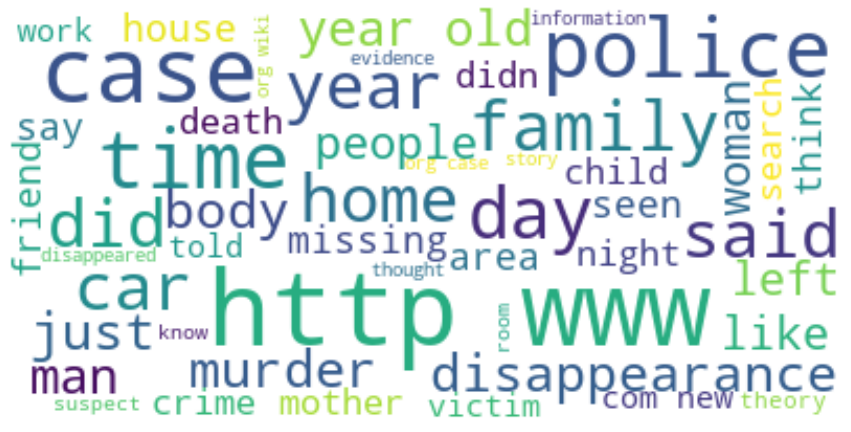

In [28]:
# to plot a 50 word wordcloud for r/unsolvedmysteries
wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white",stopwords=stop_words.ENGLISH_STOP_WORDS).generate(' '.join(df_mystery['cleaned_selftext']))

plt.figure(figsize=[15,8])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [29]:
# to subset the documents of posts of r/nosleep
df_nosleep = rejoined_train[rejoined_train['label'] == 0]

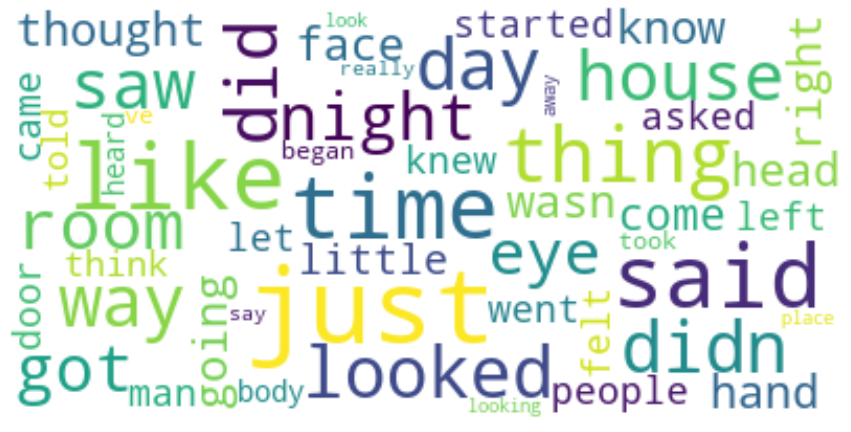

In [30]:
# to plot a 50 word wordcloud for r/nosleep
wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white",stopwords=stop_words.ENGLISH_STOP_WORDS).generate(' '.join(df_nosleep['cleaned_selftext']))

plt.figure(figsize=[15,8])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Wordcloud might look very cool for a more general crowd but it lacks dimensions such as the exact no of occurence or the absolute rank of occurence of words etc.



In [31]:
df_mystery.shape

(309, 2)

In [32]:
df_nosleep.shape

(463, 2)

In [33]:
# Instantiate a general CountVectorizer.
gcvec = CountVectorizer()

In [34]:
# Fit the vectorizer on our documents of unresolved mysteries.
list_mystery = [stories for stories in df_mystery['cleaned_selftext']]
list_mystery_gcvec = pd.DataFrame(gcvec.fit_transform(list_mystery).toarray(),
                            columns=gcvec.get_feature_names())

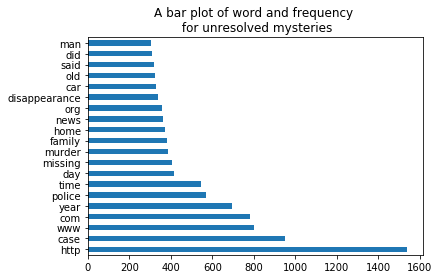

In [35]:
list_mystery_gcvec.sum().sort_values(ascending=False).head(20).plot(kind='barh',title='A bar plot of word and frequency \n for unresolved mysteries')

In [36]:
# Fit the vectorizer on our documents of nosleep.
list_nosleep = [stories for stories in df_nosleep['cleaned_selftext']]
list_nosleep_gcvec = pd.DataFrame(gcvec.fit_transform(list_nosleep).toarray(),
                            columns=gcvec.get_feature_names())

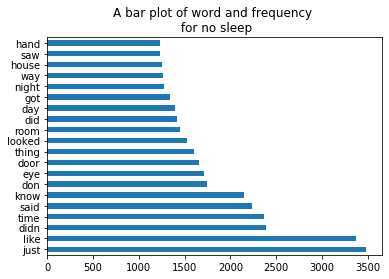

In [37]:
list_nosleep_gcvec.sum().sort_values(ascending=False).head(20).plot(kind='barh',title='A bar plot of word and frequency \n for no sleep')


<br>Given that there were 309 entries for mystery vs 463 entries for no sleep. There are far more words with >1000 counts in the top 20 words for no sleep vs only 1 word >1000 count in the top 20 words for unresolved mysteries.

The top few words for unresolved mysteries are: http, www and com are parts of URL. We will use TF-IDF to check if those words will appear if they are truly spread across the posts.
</br>

<br>

In [38]:
# Instantiate a general TFIDF Vectorizer.
gtvec = TfidfVectorizer()

In [39]:
# Fit the vectorizer on our documents of unresolved mysteries.
list_mystery_gtvec = pd.DataFrame(gtvec.fit_transform(list_mystery).toarray(),
                            columns=gtvec.get_feature_names())

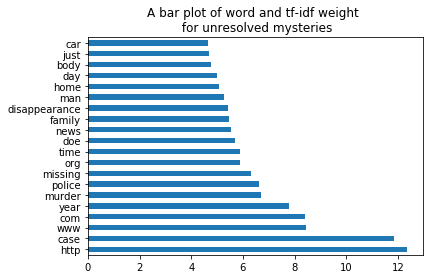

In [40]:
list_mystery_gtvec.sum().sort_values(ascending=False).head(20).plot(kind='barh',title='A bar plot of word and tf-idf weight \n for unresolved mysteries')

In [41]:
# Fit the vectorizer on our documents of nosleep.
list_nosleep_gtvec = pd.DataFrame(gtvec.fit_transform(list_nosleep).toarray(),
                            columns=gtvec.get_feature_names())

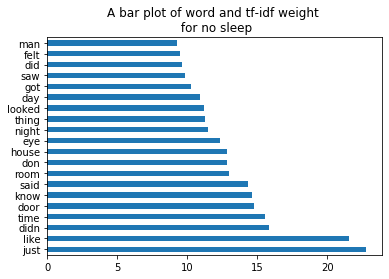

In [42]:
list_nosleep_gtvec.sum().sort_values(ascending=False).head(20).plot(kind='barh',title='A bar plot of word and tf-idf weight \n for no sleep')

After the top few words for both unresolved mysteries and no sleep remains the same. 7/10 of the top words for no sleep remained the same. 8/10 of the top words for unresolved mysteries remained the same.

That would mean that for the case of unresolved mysteries - http, www and com these few words may not be evenly spread out in all the entries.

In [43]:
len_mystery = [len(stories) for stories in list_mystery]

Text(0.5, 1.0, 'Histogram of number of words in each unresolved mysteries post')

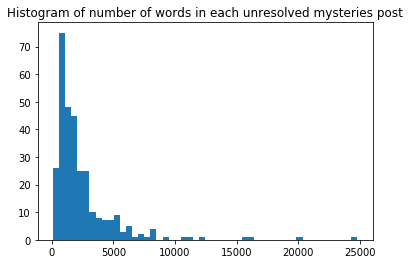

In [44]:
plt.hist(len_mystery, bins=50)
plt.title('Histogram of number of words in each unresolved mysteries post')

In [45]:
len_nosleep = [len(stories) for stories in list_nosleep]

Text(0.5, 1.0, 'Histogram of number of words in each nosleep post')

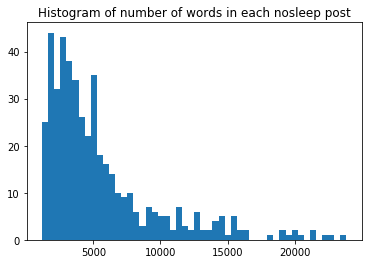

In [46]:
plt.hist(len_nosleep, bins=50)
plt.title('Histogram of number of words in each nosleep post')

# 6. Baseline model to predict

In [47]:
print(y_train.sum()/len(y_train))

0.40025906735751293


Each post has 40% to be an 'Unresolved Mysteries' post.

# 7. Models

## Pipeline creation

Our pipeline will consist of four parts:

**Naive Bayes**

**A. CountVectorizer method**
1. An instance of `CountVectorizer`
2. A Naive Bayes `MultinomialNB` instance

**B.TF-IDF Vectorizer method**
1. An instance of `TfidfVectorizer`
2. A Naive Bayes `MultinomialNB` instance

<br>

</br>

**Logistic Regression**

**C. CountVectorizer method**
1. An instance of `CountVectorizer`
2. A `LogisticRegression` instance

**D.TF-IDF Vectorizer method**
1. An instance of `TfidfVectorizer`
2. A `LogisticRegression` instance

## Naive Bayes
---

**A. CountVectorizer method**

1. An instance of `CountVectorizer`
2. A Naive Bayes `MultinomialNB` instance

Used the following params to do a gridsearch:
```
cnpipe_params = {
    'cvec__max_features': [1500, 2500, 5000],
    'cvec__min_df': [2, 3, 5, 10],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}
gs = GridSearchCV(cnpipe, param_grid=cnpipe_params, cv=5)
gs.fit(X_train, y_train)
```
returned: 

**gs.best_score_**


0.9922279792746114

**gs.best_params_**

```
{'cvec__max_df': 0.9,
 'cvec__max_features': 5000,
 'cvec__min_df': 5,
 'cvec__ngram_range': (1, 2)}

```

In [48]:
cnpipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [49]:
# changed the params to the best params so that it does not take so long to run.

cnpipe_params = {
    'cvec__max_features': [5000],
    'cvec__min_df': [5],
    'cvec__max_df': [.9],
    'cvec__ngram_range': [(1,2)]
}
gs = GridSearchCV(cnpipe, param_grid=cnpipe_params, n_jobs=-1, cv=5)
gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [50]:
gs.score(X_train,y_train)

0.9961139896373057

In [51]:
gs.score(X_test,y_test)

0.9844961240310077

In [52]:
predictions = gs.predict(X_test)

In [53]:
def metric(y_test, predictions):
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    print("True Negatives: %s" % tn)
    print("False Positives: %s" % fp)
    print("False Negatives: %s" % fn)
    print("True Positives: %s" % tp)

In [54]:
metric(y_test, predictions)

True Negatives: 143
False Positives: 0
False Negatives: 4
True Positives: 111


## Naive Bayes
---

**B.TF-IDF Vectorizer method**

1. An instance of `TfidfVectorizer`
2. A Naive Bayes `MultinomialNB` instance

Used the following params to do a gridsearch:
```
tnpipe_params = {
    'tvec__max_features': [1500, 2500, 5000],
    'tvec__min_df': [2, 3, 5, 10],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range': [(1,1), (1,2)]
}
gs = GridSearchCV(tnpipe, param_grid=tnpipe_params, cv=5)
gs.fit(X_train, y_train)
```

**gs.best_score_**


0.9909326424870466

**gs.best_params_**

```
{'tvec__max_df': 0.9,
 'tvec__max_features': 2500,
 'tvec__min_df': 10,
 'tvec__ngram_range': (1, 1)}

```

In [55]:
tnpipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [56]:
tnpipe_params = {
    'tvec__max_features': [2500],
    'tvec__min_df': [10],
    'tvec__max_df': [.9],
    'tvec__ngram_range': [(1,1)]
}
gs = GridSearchCV(tnpipe, param_grid=tnpipe_params, n_jobs=-1, cv=5)
gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                          

In [57]:
gs.score(X_train,y_train)

0.9935233160621761

In [58]:
gs.score(X_test,y_test)

0.9844961240310077

In [59]:
predictions = gs.predict(X_test)

In [60]:
metric(y_test, predictions)

True Negatives: 142
False Positives: 1
False Negatives: 3
True Positives: 112


## Logistic Regression
---

**C. CountVectorizer method**

1. An instance of `CountVectorizer`
2. A `LogisticRegression` instance

Used the following params to do a gridsearch:
```
clpipe_params = {
    'cvec__max_features': [1500, 2500, 5000],
    'cvec__min_df': [2, 3, 5, 10],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}
gs = GridSearchCV(clpipe, param_grid=clpipe_params, cv=5)
gs.fit(X_train, y_train)
```

returned:

**gs.best_score_**

0.9948186528497409

**gs.best_params_**

```
{'cvec__max_df': 0.9,
 'cvec__max_features': 1500,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

```

In [61]:
clpipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

In [62]:
clpipe_params = {
    'cvec__max_features': [1500],
    'cvec__min_df': [2],
    'cvec__max_df': [.9],
    'cvec__ngram_range': [(1,1)]
}
gs = GridSearchCV(clpipe, param_grid=clpipe_params, n_jobs=-1, cv=5)
gs.fit(X_train, y_train)

C:\Users\himyn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [63]:
gs.score(X_train,y_train)

1.0

In [64]:
gs.score(X_test,y_test)

0.9922480620155039

In [65]:
predictions = gs.predict(X_test)

In [66]:
metric(y_test, predictions)

True Negatives: 142
False Positives: 1
False Negatives: 1
True Positives: 114


## Logistic Regression
---

**D.TF-IDF Vectorizer method**
1. An instance of `TfidfVectorizer`
2. A `LogisticRegression` instance

Used the following params to do a gridsearch:
```
tlpipe_params = {
    'tvec__max_features': [1500, 2500, 5000],
    'tvec__min_df': [2, 3, 5, 10],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range': [(1,1), (1,2)]
}
gs = GridSearchCV(tlpipe, param_grid=tlpipe_params, cv=5)
gs.fit(X_train, y_train)
```

**gs.best_score_**


0.9896373056994818

**gs.best_params_**

```
{'tvec__max_df': 0.9,
 'tvec__max_features': 1500,
 'tvec__min_df': 10,
 'tvec__ngram_range': (1, 1)}

```

In [67]:
tlpipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

In [68]:
tlpipe_params = {
    'tvec__max_features': [1500],
    'tvec__min_df': [10],
    'tvec__max_df': [.9],
    'tvec__ngram_range': [(1,1)]
}
gs = GridSearchCV(tlpipe, param_grid=tlpipe_params, n_jobs=-1, cv=5)
gs.fit(X_train, y_train)

C:\Users\himyn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                          

In [69]:
gs.score(X_train,y_train)

0.9974093264248705

In [70]:
gs.score(X_test,y_test)

0.9922480620155039

In [71]:
predictions = gs.predict(X_test)

In [72]:
metric(y_test, predictions)

True Negatives: 143
False Positives: 0
False Negatives: 2
True Positives: 113


# 8. Model evaluation

In this case, incorrectly mistaking a post for a r/UnresolvedMysteries post doesn't seem much better or worse than incorrectly mistaking it for a r/Nosleep post.
Because I believe false positives and false negatives are equally as bad, I'd probably use accuracy (which is also the model score).

Since **C.) the CountVectorizer & Logistic Regression and D. )the TF-IDF & Logistic Regression** combination gives the highest score. I decide that i will proceed with **C.) the CountVectorizer & Logistic Regression** as the params for TD-IDF seems counterintuitive to have a min df of 10.

Using the params to test on unseen test.

In [73]:
cvec = CountVectorizer(max_df=0.9,max_features = 1500, min_df=2, ngram_range = (1, 1))

In [74]:
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train).toarray(),
                            columns=cvec.get_feature_names())
X_test_cvec = pd.DataFrame(cvec.transform(blind_X).toarray(),
                            columns=cvec.get_feature_names())

In [75]:
# to see the combined corpus's top 20 features
X_train_cvec.sum().sort_values(ascending=False).head(20)

just      3776
like      3628
time      2909
didn      2582
said      2553
know      2367
don       1869
http      1845
day       1810
door      1784
eye       1749
did       1725
thing     1703
room      1634
looked    1579
year      1545
got       1475
night     1449
house     1445
way       1415
dtype: int64

In [76]:
lr = LogisticRegression()

In [77]:
lr.fit(X_train_cvec, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [78]:
lr.score(X_test_cvec,blind_y)

0.9941860465116279

In [79]:
predictions = lr.predict(X_test_cvec)

In [80]:
metric(blind_y, predictions)

True Negatives: 206
False Positives: 2
False Negatives: 0
True Positives: 136


In [81]:
blind_y.reset_index(inplace=True,drop=True)
df_pred = pd.DataFrame(predictions,columns=['pred'])
joinedtruepred = pd.concat([blind_y, df_pred], axis=1)

In [82]:
joinedtruepred['error'] = joinedtruepred['label'] - joinedtruepred['pred'] 

In [83]:
joinedtruepred[joinedtruepred['error'] != 0]

,label,pred,error
43,0,1,-1
280,0,1,-1


In [87]:
# print out the wrongly predicted post
blind_X.iloc[43]

'recall little childhood say little mean remember long journey took father village market baku briefly reimagine annual festivity held outside village pleasant thought fill warm cozy nostalgia thing remember 27 year old woman currently residing working nyc childhood memory finger hand recall clear day simple albeit ominous command spilling mouth parent teacher asla geceleyin ormana gitme forest night obvious young girl deathly afraid dark dream wandering isolated forboding realm village thought violent stranger wasn t kept steadfast heeding warning fear getting lost falling menu existing wildlife region truly miss innocence existed dawn life longer live azerbaijan left country shortly fall akp father attempted work neighboring georgia armenia heated political situation shrinking economy impossible troubled nature childhood keep recalling good portion wasn t poverty isolation childhood bleak reason weren t permitted wander forest night reason good reason haunt couple continent away year

In [85]:
# print out the wrongly predicted post
blind_X.iloc[280]

'http www 9and10news com 2019 07 05 kelly boyce hurlbert hit run case remains unsolved year later live traverse city mi year week july festival called national cherry festival cherry capital world city triple population week influx tourist festival goer festival came close 2013 tragic death fact attempt lay chronologically know july 4th kelly hurlbert worked late shift local restaurant husband paul pub restaurant playing band shift ended quickly went husband wrap set set ended 1 couple stayed spent time friend shortly 2 kelly left home mere 5 block pub rode bike lived close employed night paul band equipment stayed finish packing kelly bike washington st riding road run parallel main downtown way st block north location 2 hit car impact knock bike throw bike trapped car subsequently dragged 2 block car leaf scene kelly left road call 911 ambulance arrive work stabilize police contact paul home pub thought odd kelly arrived see ambulance light porch little block away speaks police infor

# Conclusion

After testing the model with unseen data (blind_X), the model still works well with 99.4% accuracy.

Given that the top words for r/unsolvedmysteries have website url keywords inside like http, www & com. We might want to re-evaluate the model without such words as they can be a give away to classify the post.

We proceed below to create another model that drops the http, www, com words and it still works very well. 

# Bonus. Without http, www com 

In [88]:
cvec = CountVectorizer(analyzer = "word", tokenizer = None,
                             preprocessor = None, stop_words = ['http','www','com'], max_df=0.9,max_features = 1500, min_df=2, ngram_range = (1, 1))

In [89]:
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train).toarray(),
                            columns=cvec.get_feature_names())
X_test_cvec = pd.DataFrame(cvec.transform(blind_X).toarray(),
                            columns=cvec.get_feature_names())

In [90]:
# to see the combined corpus's top 20 feature
# the http, www & com disappears
X_train_cvec.sum().sort_values(ascending=False).head(20)

just      3776
like      3628
time      2909
didn      2582
said      2553
know      2367
don       1869
day       1810
door      1784
eye       1749
did       1725
thing     1703
room      1634
looked    1579
year      1545
got       1475
night     1449
house     1445
way       1415
saw       1343
dtype: int64

In [91]:
lr = LogisticRegression()

In [92]:
lr.fit(X_train_cvec, y_train)

C:\Users\himyn\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [93]:
lr.score(X_train_cvec,y_train)

1.0

In [94]:
lr.score(X_test_cvec,blind_y)

0.9912790697674418

**Still very good even without the keywords http, www and com words with a 99.1% accurarcy.**